# 1. Importando modulos necessários

In [1]:
!pip install reportlab

In [2]:
!pip install PyPDF2

In [3]:
!pip install weasyprint

In [4]:
!pip install pydata_google_auth

In [5]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from google.cloud import bigquery
from reportlab.pdfgen.canvas import Canvas
from reportlab.lib.colors import Color, black, blue, red, gray
from reportlab.lib.pagesizes import A4, landscape
from reportlab.platypus.tables import TableStyle, Table
from reportlab.pdfbase import pdfmetrics
from reportlab.platypus.paragraph import Paragraph
from reportlab.lib import styles
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate
from reportlab.lib.styles import getSampleStyleSheet
from PyPDF2 import PdfFileMerger, PdfFileWriter, PdfFileReader
import PyPDF2 
from IPython.display import HTML
import weasyprint
import pydata_google_auth
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from matplotlib import pyplot    
scaler = preprocessing.StandardScaler()

credentials = pydata_google_auth.get_user_credentials( ['https://www.googleapis.com/auth/bigquery'], )

client = bigquery.Client(location="US", credentials=credentials, project="br-apps-analytics-bigdata-dev")

# 2. Importando os dados de venda do BigQuery

In [46]:
query_job = client.query(
    """SELECT num_consumer_document_priority, ds_sector||'-'||ds_group prod, count(distinct id_sale) qtd_tickets, count(NUM_BARCODE) as qtd_items FROM `br-dolphin-ddp-prd.db_dolphin_metric_sale.tbl_sales_analytics_items`
where jobdate_split >= '2020-05-01' and jobdate_split <= '2020-07-31' and num_consumer_document_priority in (select distinct num_consumer_document_priority
FROM `br-dolphin-ddp-prd.db_dolphin_metric_sale.tbl_sales_analytics_items`
where jobdate_split >= '2020-08-01' and jobdate_split <= '2020-08-31' and num_consumer_document_priority is not null
)
group by num_consumer_document_priority,ds_sector||'-'||ds_group""",location="US",
) 
train_202007 = query_job.to_dataframe()

In [47]:
train_202007.head()

,num_consumer_document_priority,prod,qtd_tickets,qtd_items
0,20499396391.000000000,FLV-FRUTAS FRESCAS,4,11
1,40959414720.000000000,LIQUIDA-REFRIGERANTE,6,12
2,19751188806.000000000,FLV-FOLHAGEM,21,28
3,49330098215.000000000,FLV-FRUTAS FRESCAS,7,12
4,28498357810.000000000,SALSICHARIA-QUEIJOS,4,11


In [48]:
train_202007=pd.pivot_table(train_202007, values = ['qtd_tickets','qtd_items'], index=['num_consumer_document_priority'],columns=['prod'], aggfunc=np.sum, fill_value=0).reset_index()

In [49]:
train_202007.head()

num_consumer_document_priority    qtd_items                 \
prod                                ACOUGUE-AVES ACOUGUE-BOVINO   
0                              0E-9            4             12   
1                    8176.000000000            0              0   
2                   40142.000000000           10              0   
3                   57380.000000000            3              2   
4                   71706.000000000            0              0   

                                                                      \
prod ACOUGUE-ESPETINHOS ACOUGUE-EXOTICOS ACOUGUE-SUINO ACOUGUE-SWIFT   
0                     0                0             0             0   
1                     0                0             0             0   
2                     0                0             0             0   
3                     0                0            13             0   
4                     0                0             0             0   

                                                    ...    qtd_tickets  \
prod ACOUGUE-SWIFT ACOUGUE BEBE-BEBE BEBE-INFANTIL  ... TV E VIDEO-LED   
0                        0         1            17  ...              0   
1                        0         0             0  ...              0   
2                        0         0             0  ...              0   
3                        0         0             0  ...              0   
4                        0         0             0  ...              0   

                                                                            \
prod TV E VIDEO-OLED TV E VIDEO-TV FHD TV E VIDEO-TV HD TV E VIDEO-TV NANO   
0                  0                 0                0                  0   
1                  0                 0                0                  0   
2                  0                 0                0                  0   
3                  0                 0                0                  0   
4                  0                 0                0                  0   

                                                                             \
prod TV E VIDEO-TV OLED TV E VIDEO-TV QLED TV E VIDEO-TV UHD TV E VIDEO-UHD   
0                     0                  0                 0              1   
1                     0                  0                 0              0   
2                     0                  0                 0              0   
3                     0                  0                 0              0   
4                     0                  0                 0              0   

                            
prod VASILHAMES-VASILHAMES  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 507 columns]

In [50]:
query_job = client.query(
    """SELECT num_consumer_document_priority, max(case when ds_sector = 'LIQUIDA' AND ds_group = 'CERVEJA' then 1 else 0 end) fl_comprou_cerveja
FROM `br-dolphin-ddp-prd.db_dolphin_metric_sale.tbl_sales_analytics_items`
where jobdate_split >= '2020-08-01' and jobdate_split <= '2020-08-31' 
and num_consumer_document_priority in (select distinct num_consumer_document_priority
from `br-dolphin-ddp-prd.db_dolphin_metric_sale.tbl_sales_analytics_items`
where jobdate_split >= '2020-05-01' and jobdate_split <= '2020-07-31' and num_consumer_document_priority is not null)
group by num_consumer_document_priority""",location="US",
) 
target_202007 = query_job.to_dataframe()

In [51]:
query_job = client.query(
    """SELECT num_consumer_document_priority, ds_sector||'-'||ds_group prod, count(distinct id_sale) qtd_tickets, count(NUM_BARCODE) as qtd_items FROM `br-dolphin-ddp-prd.db_dolphin_metric_sale.tbl_sales_analytics_items`
where jobdate_split >= '2020-06-01' and jobdate_split <= '2020-08-31' and num_consumer_document_priority in (select distinct num_consumer_document_priority
FROM `br-dolphin-ddp-prd.db_dolphin_metric_sale.tbl_sales_analytics_items`
where jobdate_split >= '2020-09-01' and jobdate_split <= '2020-09-30' and num_consumer_document_priority is not null
)
group by num_consumer_document_priority,ds_sector||'-'||ds_group""",location="US",
) 
train_202008 = query_job.to_dataframe()

In [52]:
train_202008=pd.pivot_table(train_202008, values = ['qtd_tickets','qtd_items'], index=['num_consumer_document_priority'],columns=['prod'], aggfunc=np.sum, fill_value=0).reset_index()

In [53]:
train_202008.head()

num_consumer_document_priority    qtd_items                 \
prod                                ACOUGUE-AVES ACOUGUE-BOVINO   
0                              0E-9            4             12   
1                     191.000000000            0              0   
2                   40142.000000000            2              0   
3                   57380.000000000            3              0   
4                   71706.000000000            0              0   

                                                                      \
prod ACOUGUE-ESPETINHOS ACOUGUE-EXOTICOS ACOUGUE-SUINO ACOUGUE-SWIFT   
0                     0                0             0             0   
1                     0                0             0             0   
2                     0                0             0             0   
3                     0                0             7             0   
4                     0                0             0             0   

                                                    ...    qtd_tickets  \
prod ACOUGUE-SWIFT ACOUGUE BEBE-BEBE BEBE-INFANTIL  ... TV E VIDEO-LED   
0                        0         1            17  ...              0   
1                        0         0             0  ...              0   
2                        0         0             0  ...              0   
3                        0         0             0  ...              0   
4                        0         0             0  ...              0   

                                                                            \
prod TV E VIDEO-OLED TV E VIDEO-TV FHD TV E VIDEO-TV HD TV E VIDEO-TV NANO   
0                  0                 0                0                  0   
1                  0                 0                0                  0   
2                  0                 0                0                  0   
3                  0                 0                0                  0   
4                  0                 0                0                  0   

                                                                             \
prod TV E VIDEO-TV OLED TV E VIDEO-TV QLED TV E VIDEO-TV UHD TV E VIDEO-UHD   
0                     0                  0                 0              1   
1                     0                  0                 0              0   
2                     0                  0                 0              0   
3                     0                  0                 0              0   
4                     0                  0                 0              0   

                            
prod VASILHAMES-VASILHAMES  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 509 columns]

In [54]:
train_202008.shape

(1696164, 509)

In [55]:
query_job = client.query(
    """SELECT num_consumer_document_priority, max(case when ds_sector = 'LIQUIDA' AND ds_group = 'CERVEJA' then 1 else 0 end) fl_comprou_cerveja
FROM `br-dolphin-ddp-prd.db_dolphin_metric_sale.tbl_sales_analytics_items`
where jobdate_split >= '2020-09-01' and jobdate_split <= '2020-09-30' 
and num_consumer_document_priority in (select distinct num_consumer_document_priority
from `br-dolphin-ddp-prd.db_dolphin_metric_sale.tbl_sales_analytics_items`
where jobdate_split >= '2020-06-01' and jobdate_split <= '2020-08-31' and num_consumer_document_priority is not null)
group by num_consumer_document_priority""",location="US",
) 
target_202008 = query_job.to_dataframe()

In [56]:
target_202008.head()

,num_consumer_document_priority,fl_comprou_cerveja
0,11892985977.000000000,0
1,16718393746.000000000,0
2,98456059668.000000000,0
3,40084856866.000000000,0
4,869037056.000000000,0


In [57]:
target_202008.shape

(1696262, 2)

In [58]:
train_202007.columns = ['_'.join(col) for col in train_202007.columns]

In [59]:
train_202008.columns = ['_'.join(col) for col in train_202008.columns]

In [68]:
vars=train_202007.columns.values.tolist()
vars.remove('num_consumer_document_priority_')

In [61]:
desenv=train_202007.join(target_202007.set_index('num_consumer_document_priority'), on='num_consumer_document_priority_')

In [62]:
desenv.head()

,num_consumer_document_priority_,qtd_items_ACOUGUE-AVES,qtd_items_ACOUGUE-BOVINO,qtd_items_ACOUGUE-ESPETINHOS,qtd_items_ACOUGUE-EXOTICOS,qtd_items_ACOUGUE-SUINO,qtd_items_ACOUGUE-SWIFT,qtd_items_ACOUGUE-SWIFT ACOUGUE,qtd_items_BEBE-BEBE,qtd_items_BEBE-INFANTIL,...,qtd_tickets_TV E VIDEO-OLED,qtd_tickets_TV E VIDEO-TV FHD,qtd_tickets_TV E VIDEO-TV HD,qtd_tickets_TV E VIDEO-TV NANO,qtd_tickets_TV E VIDEO-TV OLED,qtd_tickets_TV E VIDEO-TV QLED,qtd_tickets_TV E VIDEO-TV UHD,qtd_tickets_TV E VIDEO-UHD,qtd_tickets_VASILHAMES-VASILHAMES,fl_comprou_cerveja
0,0E-9,4,12,0,0,0,0,0,1,17,...,0,0,0,0,0,0,0,1,0,0
1,8176.000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,40142.000000000,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57380.000000000,3,2,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,71706.000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
valid=train_202008.join(target_202008.set_index('num_consumer_document_priority'), on='num_consumer_document_priority_')

In [64]:
valid.head()

,num_consumer_document_priority_,qtd_items_ACOUGUE-AVES,qtd_items_ACOUGUE-BOVINO,qtd_items_ACOUGUE-ESPETINHOS,qtd_items_ACOUGUE-EXOTICOS,qtd_items_ACOUGUE-SUINO,qtd_items_ACOUGUE-SWIFT,qtd_items_ACOUGUE-SWIFT ACOUGUE,qtd_items_BEBE-BEBE,qtd_items_BEBE-INFANTIL,...,qtd_tickets_TV E VIDEO-OLED,qtd_tickets_TV E VIDEO-TV FHD,qtd_tickets_TV E VIDEO-TV HD,qtd_tickets_TV E VIDEO-TV NANO,qtd_tickets_TV E VIDEO-TV OLED,qtd_tickets_TV E VIDEO-TV QLED,qtd_tickets_TV E VIDEO-TV UHD,qtd_tickets_TV E VIDEO-UHD,qtd_tickets_VASILHAMES-VASILHAMES,fl_comprou_cerveja
0,0E-9,4,12,0,0,0,0,0,1,17,...,0,0,0,0,0,0,0,1,0,0
1,191.000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,40142.000000000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57380.000000000,3,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,71706.000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
desenv[desenv['fl_comprou_cerveja']==1].shape

(273800, 508)

# 3. Modelando...

In [69]:
foco = vars.copy()
foco.append('fl_comprou_cerveja')
bad=desenv[desenv['fl_comprou_cerveja']==1][foco].sample(n=50000, random_state=1)
good=desenv[desenv['fl_comprou_cerveja']==0][foco].sample(n=50000, random_state=1)
train=pd.concat([bad, good], ignore_index=True)

In [70]:
train.shape

(100000, 507)

In [71]:
train[vars].shape

(100000, 506)

In [72]:
train_norm=scaler.fit_transform(train[vars])
valid_norm=scaler.fit_transform(valid[vars])

In [78]:
#grid={"penalty":["l1","l2"]} # l1 lasso l2 ridge
logreg_cv=LogisticRegression(max_iter=1000)
#logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(train_norm,train['fl_comprou_cerveja'])

LogisticRegression(max_iter=1000)

In [79]:
print('fl_comprou_cerveja')
#print(logreg_cv.best_params_)
print(classification_report(valid['fl_comprou_cerveja'], logreg_cv.predict(valid_norm)))

fl_comprou_cerveja
              precision    recall  f1-score   support

           0       0.93      0.79      0.85   1424486
           1       0.38      0.68      0.49    271678

    accuracy                           0.77   1696164
   macro avg       0.65      0.73      0.67   1696164
weighted avg       0.84      0.77      0.79   1696164



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.785


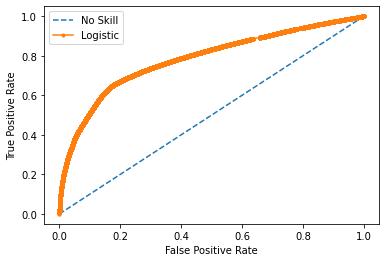

In [80]:
# predict probabilities
ns_probs = [0 for _ in range(len(valid['fl_comprou_cerveja']))]
lr_probs = logreg_cv.predict_proba(valid_norm)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(valid['fl_comprou_cerveja'], ns_probs)
lr_auc = roc_auc_score(valid['fl_comprou_cerveja'], lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(valid['fl_comprou_cerveja'], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(valid['fl_comprou_cerveja'], lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [81]:
valid['prob_'+'fl_comprou_cerveja']=logreg_cv.predict_proba(valid_norm)[:, 1]
valid['pred_'+'fl_comprou_cerveja']=logreg_cv.predict(valid_norm)

In [83]:
valid[valid.pred_fl_comprou_cerveja==1]['num_consumer_document_priority_'].head()

1       191.000000000
3     57380.000000000
6     87106.000000000
7    119679.000000000
9    141682.000000000
Name: num_consumer_document_priority_, dtype: object

In [82]:
valid[valid.pred_fl_comprou_cerveja==1]['num_consumer_document_priority_'].to_csv('cpfs_preditos.csv')